In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import pandas as pd
import shutil, os
import glob
import numpy as np
from tqdm import tqdm

In [ ]:
#import data for xrays and RLEs
labels = pd.read_csv("data/train-rle.csv")

imageIds = labels.ImageId
rles = labels.EncodedPixels

In [ ]:
#COLLECT TEST PATHS
#test_files = glob.glob('data/dicom-images-test/**/**/*.dcm')

In [ ]:
#COLLECT TRAINING PATHS & COPY TO DEST
# train_files = glob.glob('data/dicom-images-train/**/**/*.dcm')
# dest = 'data/images'
# for f in train_files:
#     shutil.copy(f, dest)

In [ ]:
import pydicom
import matplotlib
import matplotlib.pyplot as plt
import gdcm

import scipy.ndimage as ndimage
from functools import partial
from scipy.ndimage.filters import gaussian_filter
ii16 = np.iinfo(np.int16) 

SIZE = 1024

# CONFIRM DATA SIZE AND DICOM HEADER
dest = 'data/images'
for f in tqdm(os.listdir(dest)):
    try:
        image = pydicom.dcmread(os.path.join(dest,f))
        if image.pixel_array.shape != (SIZE, SIZE):
            print("******abnormal data shape ******")
    except Exception:
        print(f)

In [ ]:
id2rles = {}

for i, id_key in enumerate(imageIds):
    value = rles[i]
    id2rles.setdefault(id_key, []).append(value)

In [ ]:
#Sample Dict Item
key = "1.2.276.0.7230010.3.1.4.8323329.4794.1517875184.840760"
vals = id2rles[key]
print("Sample id2rle dictionary id and result:   \nKEY:", key,"   \nRESULT:", vals)

In [ ]:
from mask_functions import MaskRleCode as mr
from scipy import misc

In [ ]:
# EXPORTING ALL DICOM DATA AS PNG WITH CLAHE FILTERS BELOW - V1
# !cd ~/Dev/kaggle-pneumothorax/data
# python histogram_process.py -p images/ -cl 0.01 -b 10000 -e
# Namespace(bins=10000, cliplimit='0.01', export=True, index=None, level=None, path='images/', window=None)

In [ ]:
def rles2CombinedMask(image_name, rles, dest='data/labels'):
    
    mask = np.zeros((SIZE,SIZE))
    
    for i, r in enumerate(rles):
        if(r!=" -1"):
            mask = np.maximum(mask,mr.rle2mask(r, SIZE, SIZE))
        
    #saves combined mask
    mask = mask / 255
    mask = mask.astype(dtype=np.uint8)
    misc.imsave(os.path.join(dest,image_name) +".dcm_P.png", mask)

In [ ]:
#CONVERTS ALL MASK RLEs TO MERGED PNG OUTPUT IMAGE
for key, value_list in tqdm(id2rles.items()):
    rles2CombinedMask(key, value_list)

In [1]:
########################################
## DATA SET UP COMPLETED
## MODEL CODE WITH FAST-AI FRAMEWORK BELOW
########################################

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

import psutil
psutil.virtual_memory()

svmem(total=67211718656, available=57695277056, percent=14.2, used=8308674560, free=22492172288, active=26013941760, inactive=13707616256, buffers=5382459392, cached=31028412416, shared=457469952, slab=4360486912)

In [3]:
fastai.__version__

'1.0.55'

In [4]:
path = Path('data/')
path.ls()

[PosixPath('data/labels'),
 PosixPath('data/xrays'),
 PosixPath('data/dicom-images-train'),
 PosixPath('data/codes.txt'),
 PosixPath('data/images'),
 PosixPath('data/images_dicom'),
 PosixPath('data/train-rle.csv'),
 PosixPath('data/histogram_process.py'),
 PosixPath('data/dicom-images-test')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

In [6]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [7]:
fnames.index(Path('data/images/1.2.276.0.7230010.3.1.4.8323329.13831.1517875248.167238.dcm.png'))

811

data/images/1.2.276.0.7230010.3.1.4.8323329.13831.1517875248.167238.dcm.png


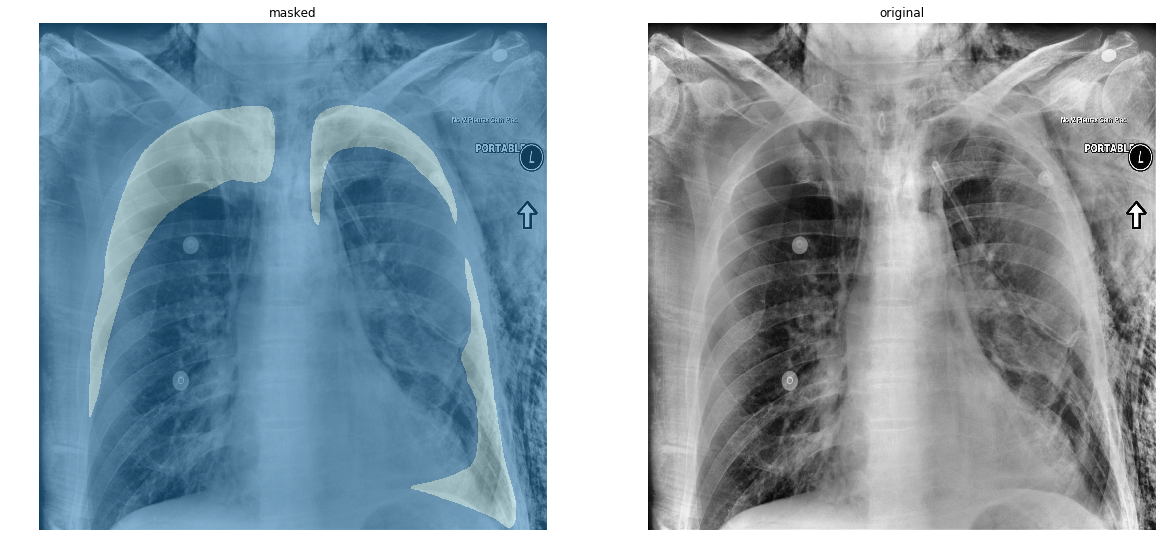

In [8]:
img_f = fnames[811]
print(fnames[811])

img = open_image(img_f)
mask = open_mask(get_y_fn(img_f))

_,axs = plt.subplots(1,2, figsize=(20,10))

img.show(ax=axs[0], figsize=(10,10), y=mask, title='masked', alpha=0.5)
img.show(ax=axs[1], figsize=(10,10), title='original')


In [9]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([1024, 1024]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Normal', 'Pneumothorax'], dtype='<U12')

In [11]:
size = src_size//4
print("reduced size ", size)
free = gpu_mem_get_free_no_cache()
psutil.virtual_memory()
# the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

bs = 4

reduced size  [256 256]


In [12]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes)) ## ADD TEST FOLDER

In [13]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [14]:
data.classes

array(['Normal', 'Pneumothorax'], dtype='<U12')

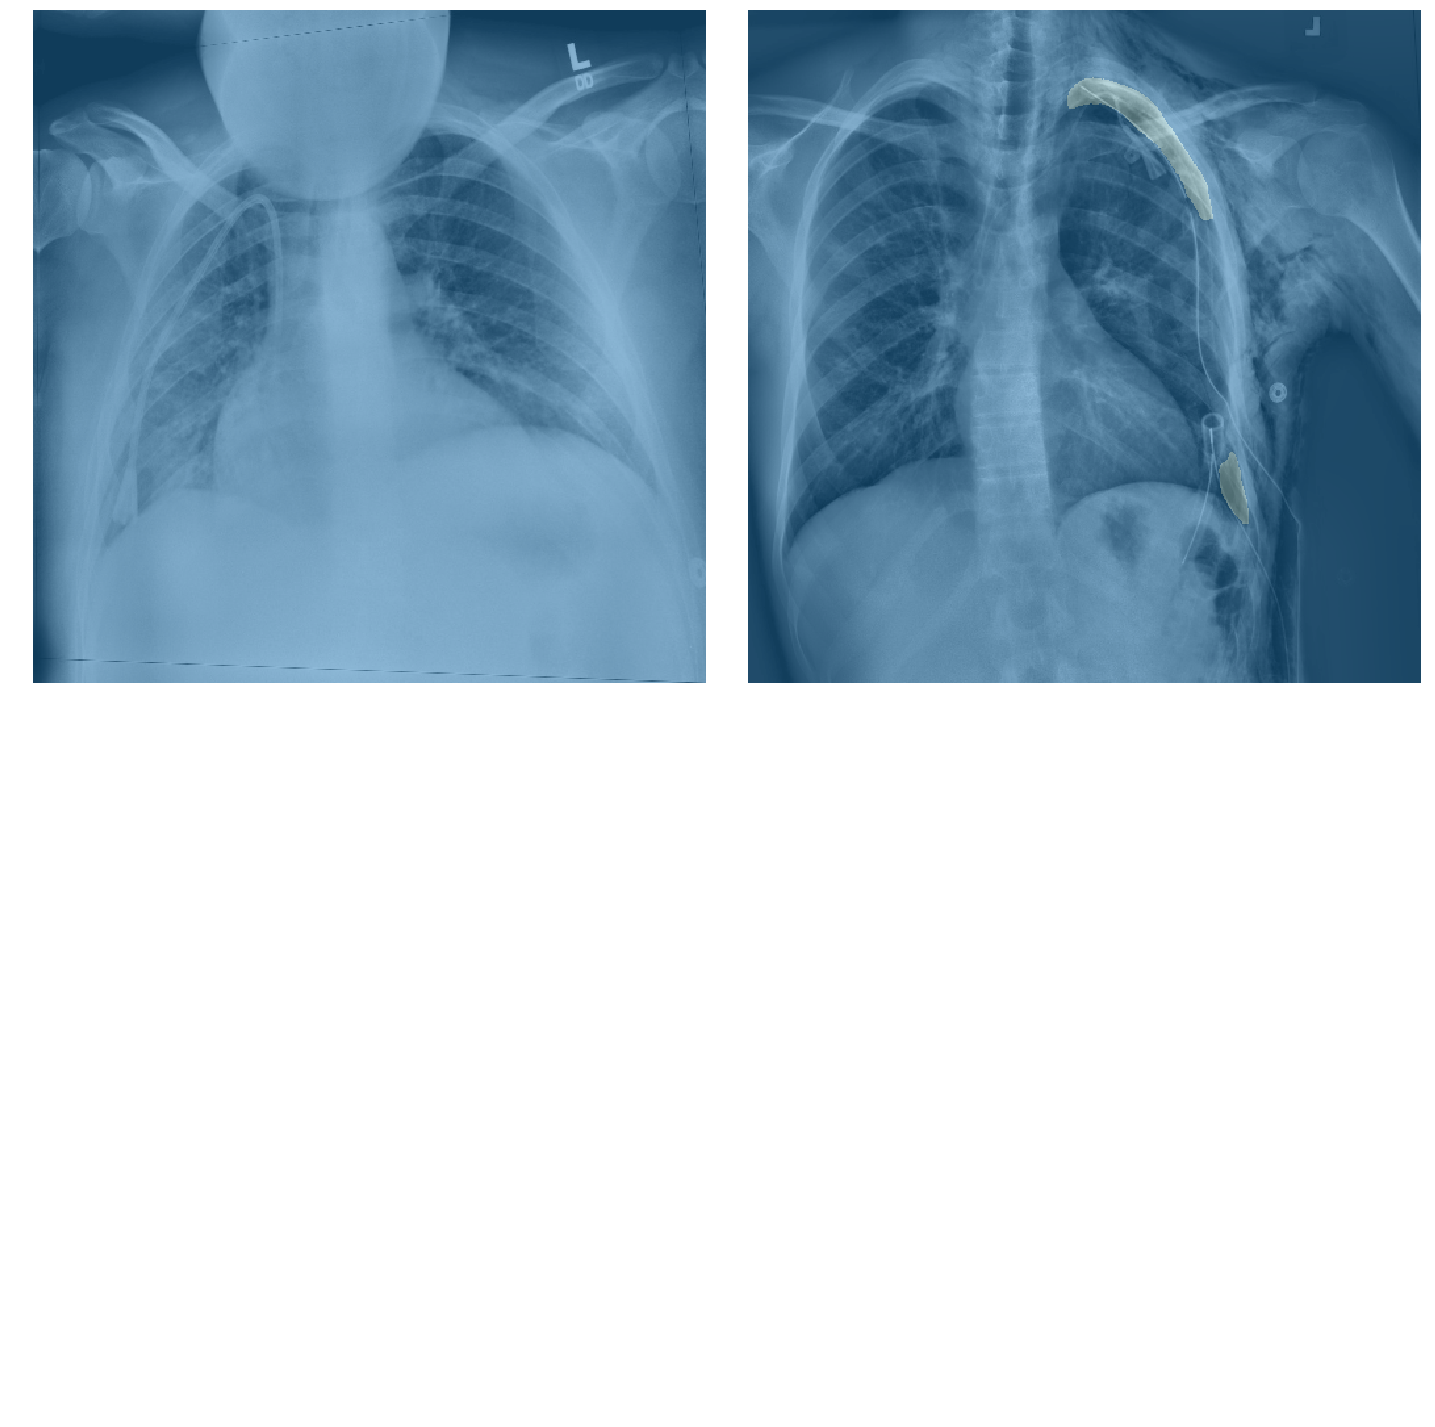

In [96]:
data.show_batch(10, figsize=(20,20), alpha=0.5)

In [15]:
def acc(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [16]:
metrics=[acc, dice]

In [17]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=1e-5)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
#learn.save('stage-1-data-v4')

In [18]:
learn.load('stage-1-data-v4')

Learner(data=ImageDataBunch;

Train: LabelList (8540 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/images;

Valid: LabelList (2134 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(k

In [ ]:
learn.unfreeze()
lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(12, lrs, pct_start=0.8)

learn.save('stage-1b-data-v4')


In [19]:
# Predictions for the validation set
preds, ys = learn.get_preds()
preds = preds[:,1,...]
ys = ys.squeeze()

In [21]:
learn.metrics

[<function __main__.acc(input, target)>,
 <function fastai.metrics.dice(input: torch.Tensor, targs: torch.Tensor, iou: bool = False, eps: float = 1e-08) -> <function NewType.<locals>.new_type at 0x7f1db7711bf8>>]

In [86]:
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)

In [87]:
# Find optimal threshold
dices = []
thrs = np.arange(0.01, 1, 0.01)
for i in progress_bar(thrs):
    preds_m = (preds>i).long()
    dices.append(dice_overall(preds_m, ys).mean())
dices = np.array(dices)

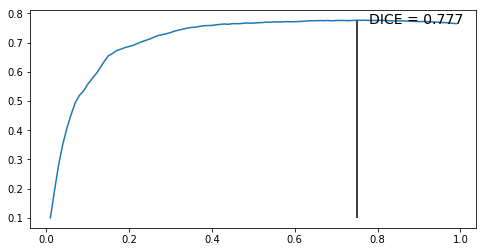

In [88]:
best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

In [91]:
print(best_thr)

0.75


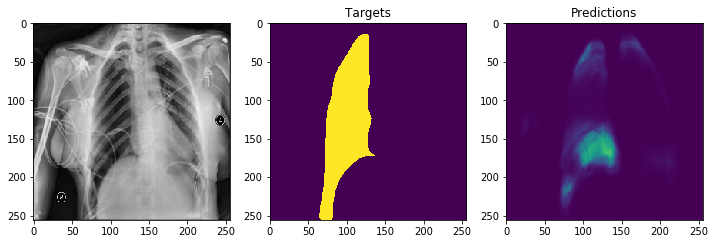

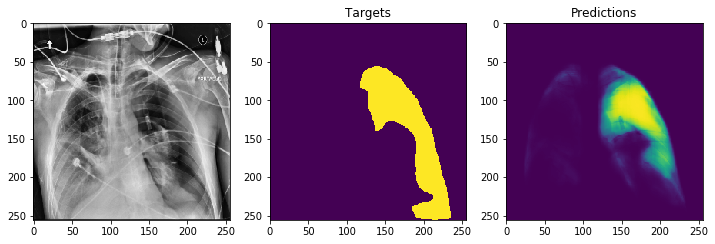

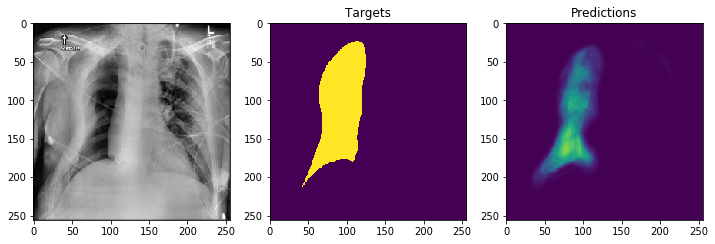

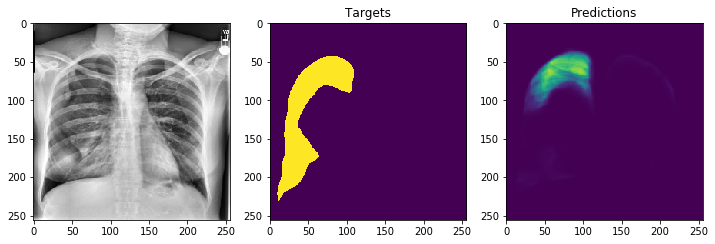

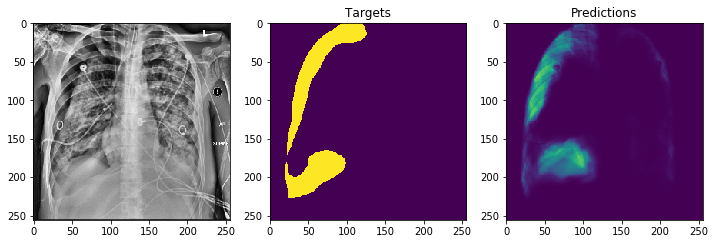

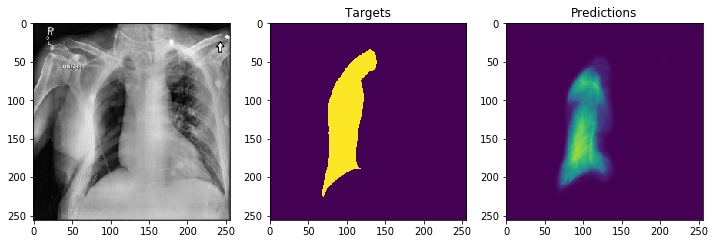

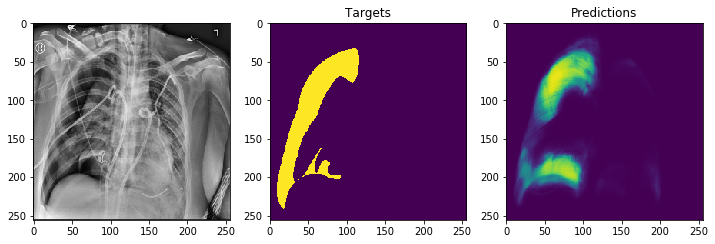

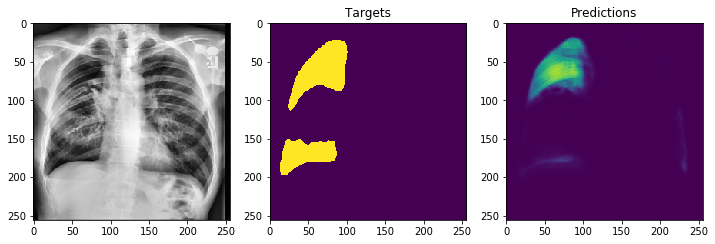

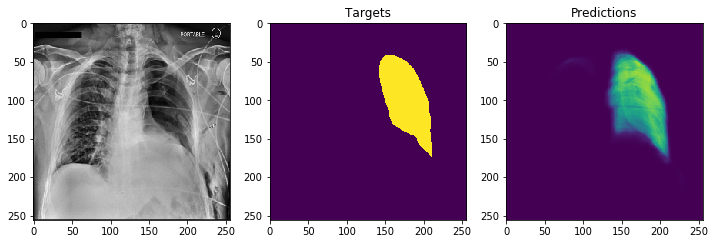

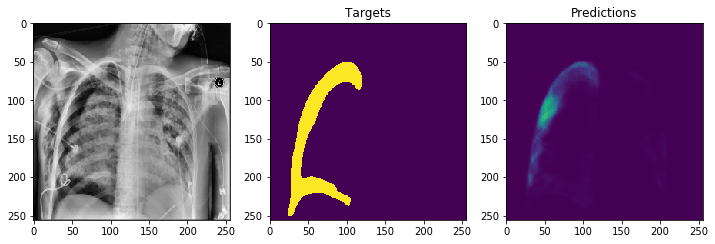

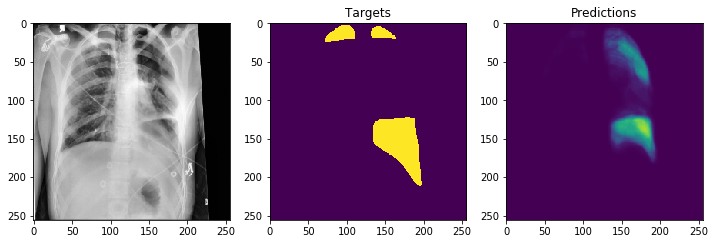

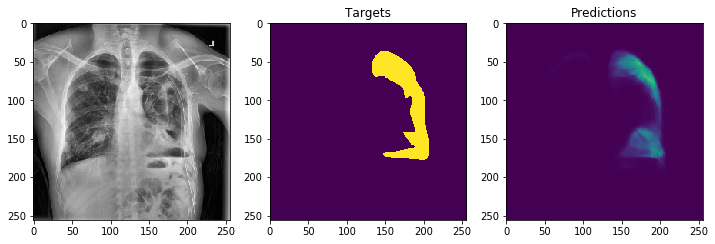

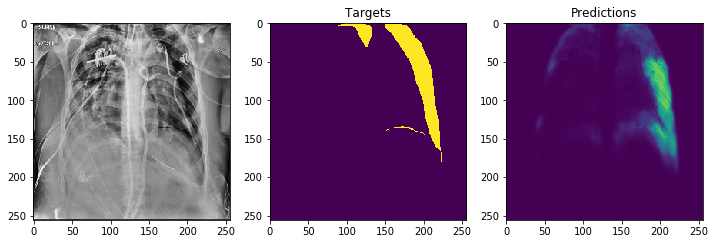

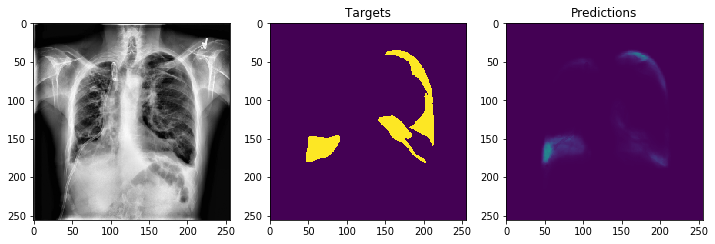

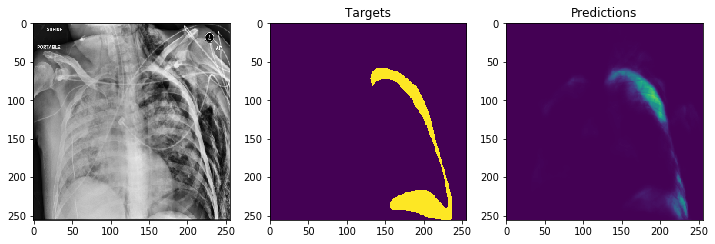

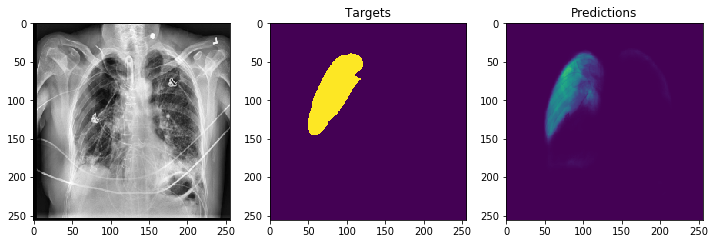

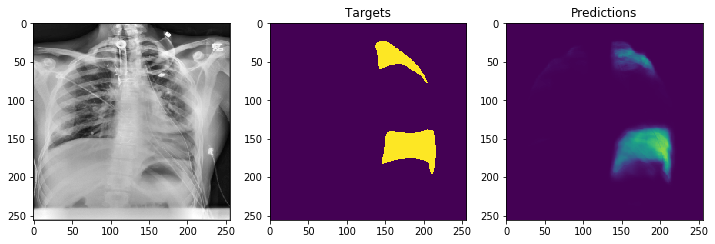

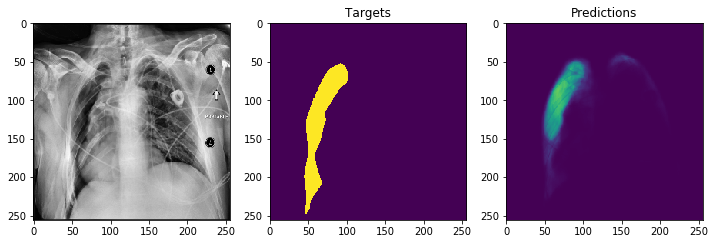

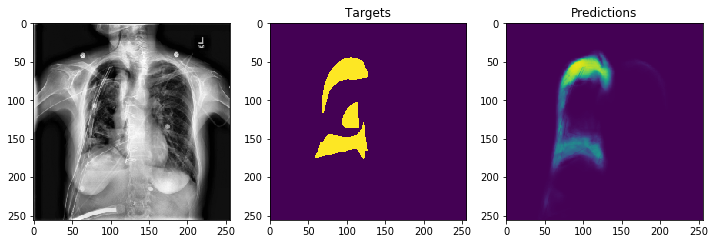

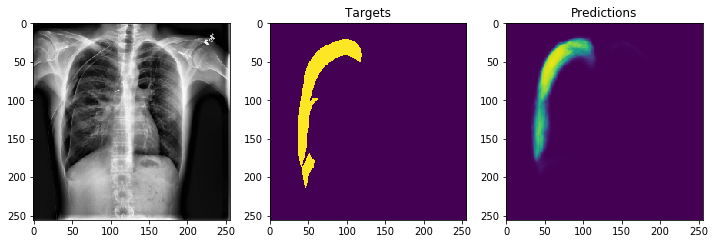

In [30]:
# Plot some samples
rows = 20
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


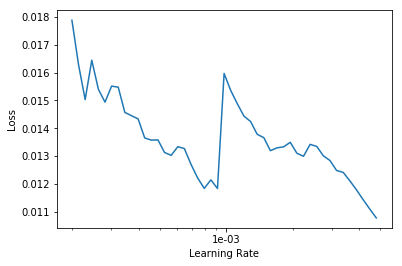

In [17]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=1e-5)
learn.load('stage-1b-data-v4')
learn.lr_find(start_lr=1e-4, end_lr=1e-1)
learn.recorder.plot()



In [18]:
size = src_size//2
print("reduced size ", size)
free = gpu_mem_get_free_no_cache()

# the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

bs = 2

reduced size  [512 512]


In [19]:
psutil.virtual_memory()

svmem(total=67211718656, available=57119395840, percent=15.0, used=8699895808, free=33946353664, active=19434061824, inactive=9458356224, buffers=3855310848, cached=20710158336, shared=642166784, slab=3695198208)

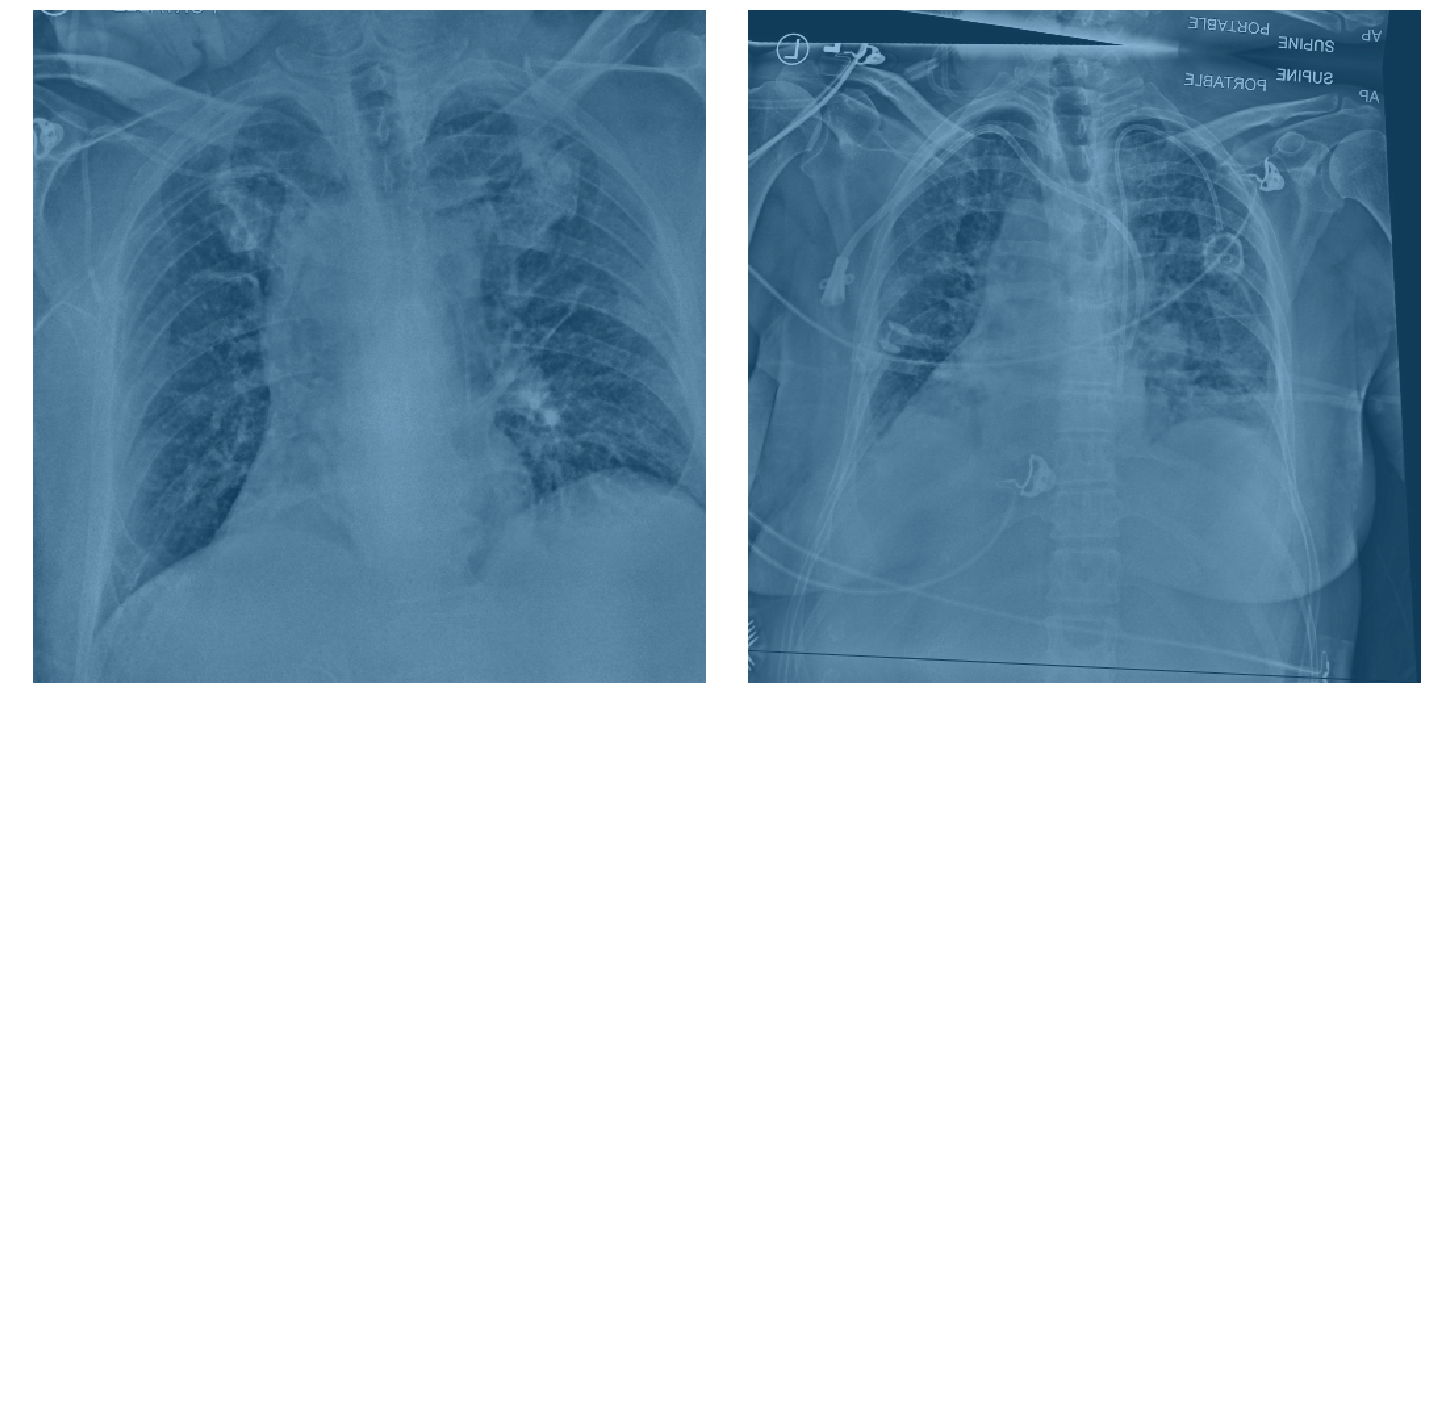

In [20]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes)) ## ADD TEST FOLDER

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

data.show_batch(3, figsize=(20,20), alpha=0.5)

In [21]:
lr = 1e-5
lrs = slice(lr/400,lr)
learn.unfreeze()

In [22]:
learn.fit_one_cycle(20, lrs)

In [31]:
learn.load('stage-2-data-v4-512')

Learner(data=ImageDataBunch;

Train: LabelList (8540 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/images;

Valid: LabelList (2134 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(k

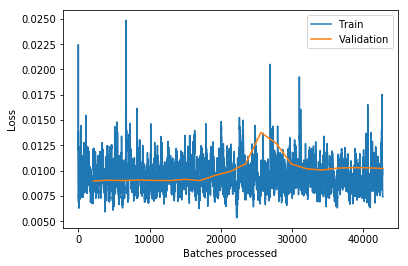

In [23]:
learn.recorder.plot_losses()

In [39]:
# Predictions for the validation set
preds, ys = learn.get_preds()
preds = preds[:,1,...]
ys = ys.squeeze()

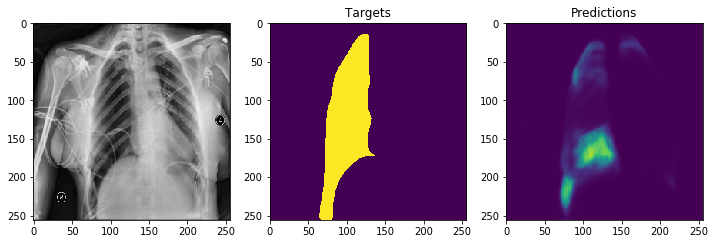

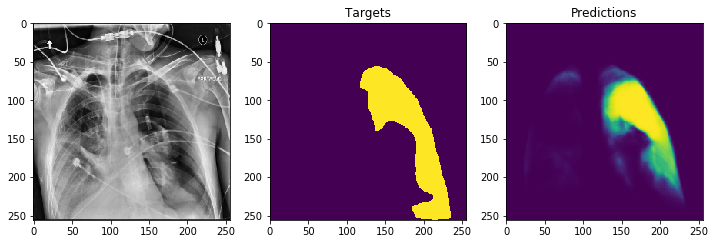

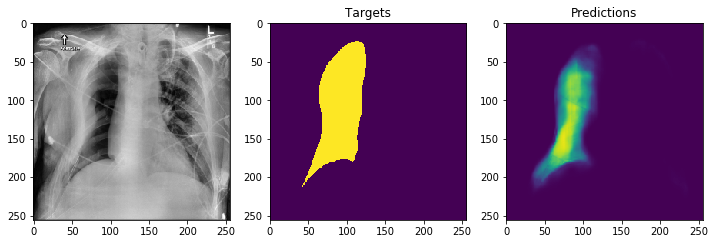

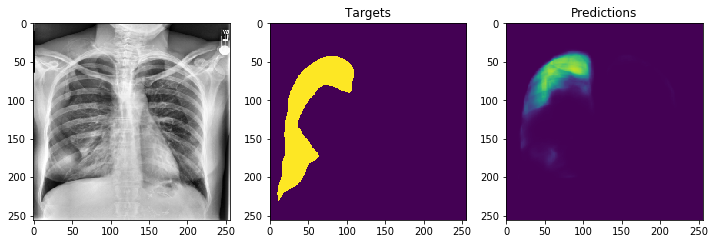

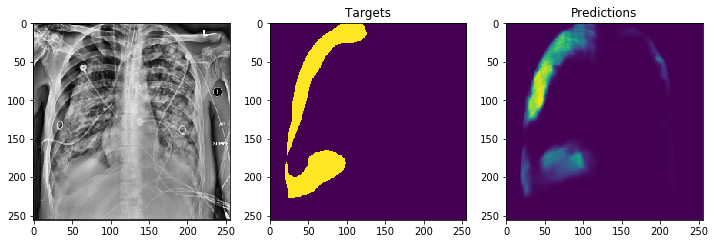

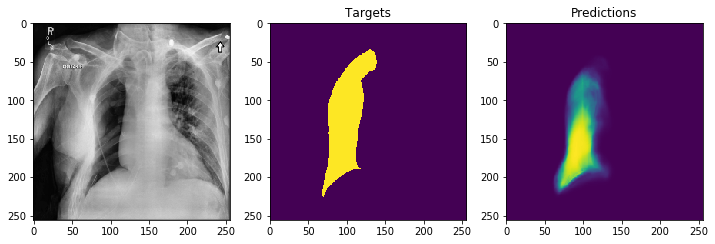

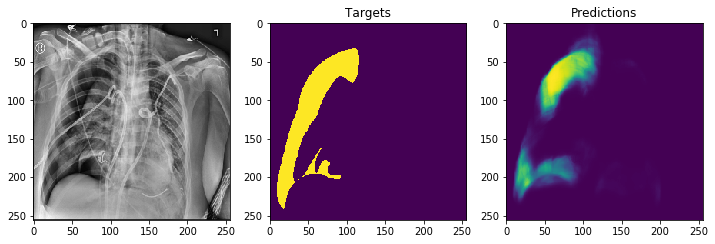

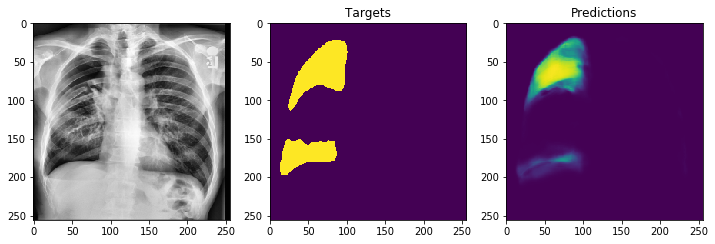

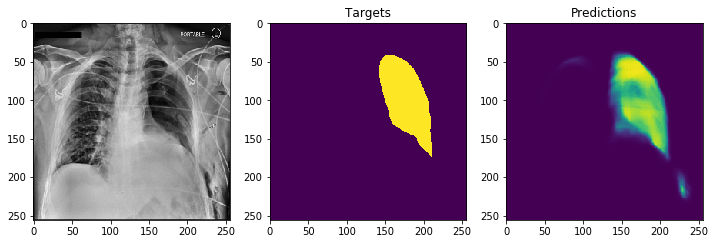

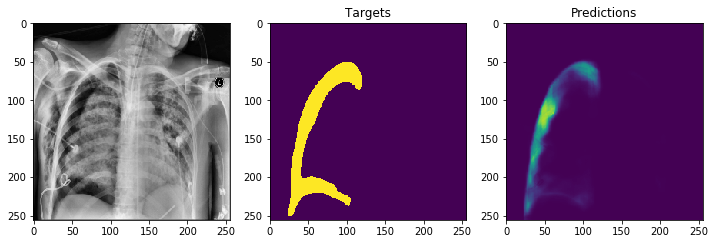

In [40]:
# Plot some samples
rows = 10
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

In [36]:
# Calculating Lovasz Hinge Loss
# https://arxiv.org/abs/1705.08790
# https://github.com/bermanmaxim/LovaszSoftmax/blob/master/pytorch/lovasz_losses.py

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


# --------------------------- HELPER FUNCTIONS ---------------------------

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

In [37]:
def lovasz_loss(logits, labels):
    labels, logits = labels.squeeze(1), logits.squeeze(1)
    labels = torch.Tensor(labels.data.cpu().numpy()).cuda()
    loss = lovasz_hinge(logits, labels, per_image = True, ignore = None)
    return loss

In [38]:
# The evaluation metric: mean average precision at 
# different intersection over union (IoU) thresholds.

# Inspired by Kerem Turgutlu:
# https://github.com/KeremTurgutlu/airbus/blob/master/eval_metric.py

def IOU(pred, targ):
    smooth = 1e-6
    intersection = np.sum(pred * targ)
    union = np.sum((pred + targ) > 0)
    return (intersection + smooth) / (union + smooth)

def avg_precision_IOU(pred, targ):
    IOU_score = IOU(pred, targ)
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        prec.append((IOU_score > t).astype('uint8'))
    return np.mean(prec)

def mean_avg_precision_IOU(preds, targs, thresh=0.0):
    scores = []
    preds = (to_np(preds) > thresh).astype('uint8')
    targs = to_np(targs)
    for i, (pred_i, targ_i) in enumerate(zip(preds, targs)):
        pred_i, targ_i = scale_min(pred_i, 101), scale_min(targ_i, 101)
        scores.append(avg_precision_IOU(pred_i, targ_i))
    return np.mean(scores)

In [29]:
psutil.virtual_memory()

svmem(total=67211718656, available=53803790336, percent=19.9, used=12004786176, free=29364535296, active=23638867968, inactive=9795620864, buffers=4227276800, cached=21615120384, shared=652656640, slab=3729436672)

In [39]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes)) ## ADD TEST FOLDER

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


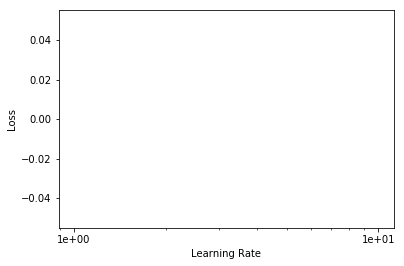

In [40]:
learn.lr_find(start_lr=1e-7, end_lr=1e-1)
learn.recorder.plot()

In [41]:
learn.load('stage-2-data-v4-512')

Learner(data=ImageDataBunch;

Train: LabelList (8540 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/images;

Valid: LabelList (2134 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(k

In [42]:
learn.crit=lovasz_loss
lr = 1e-5
lrs = slice(lr/400,lr)
learn.unfreeze()

In [49]:
def addSaveCallback(learner): 
    learner.callback_fns.append(partial(callbacks.SaveModelCallback, monitor='dice', mode='max', name='tmp'))

In [ ]:
addSaveCallback(learn)

learn.fit_one_cycle(20, lrs)

/home/aksg87/anaconda3/lib/python3.7/site-packages/fastai/callbacks/tracker.py:50: UserWarning: <class 'fastai.callbacks.tracker.SaveModelCallback'> conditioned on metric `error_rate` which is not available. Available metrics are: train_loss, valid_loss, acc, dice
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:-1]))}')


In [35]:
learn.load('stage-3-data-v4-512-lovasz')

Learner(data=ImageDataBunch;

Train: LabelList (8540 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/images;

Valid: LabelList (2134 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(k

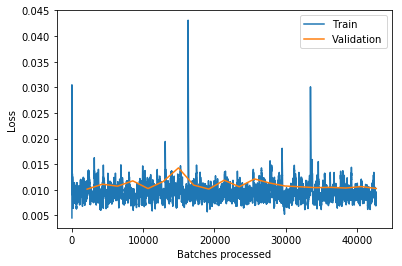

In [53]:
learn.recorder.plot_losses()

In [36]:
# Predictions for the validation set
preds, ys = learn.get_preds()
preds = preds[:,1,...]
ys = ys.squeeze()

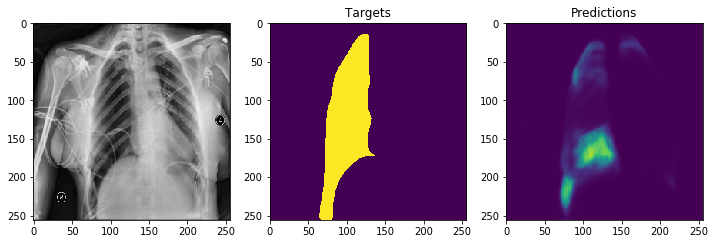

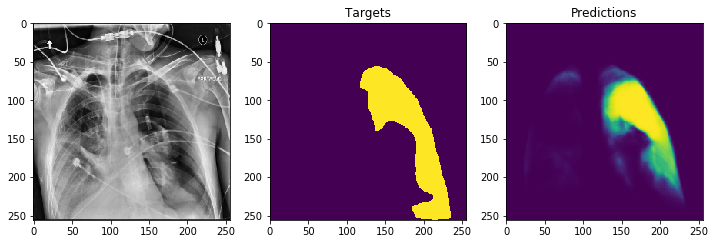

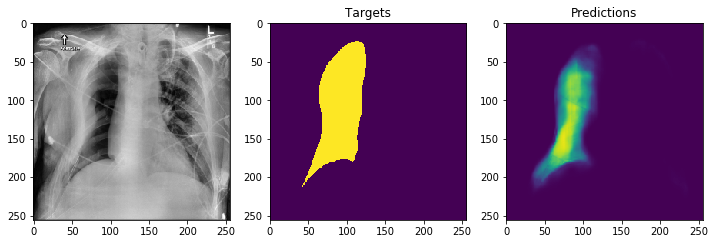

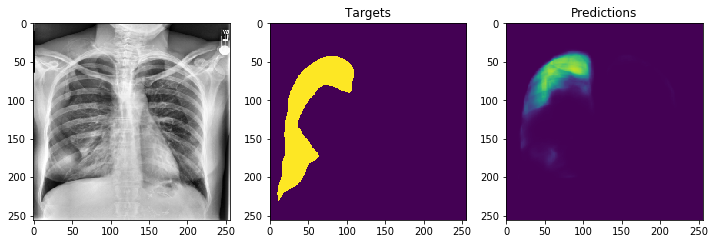

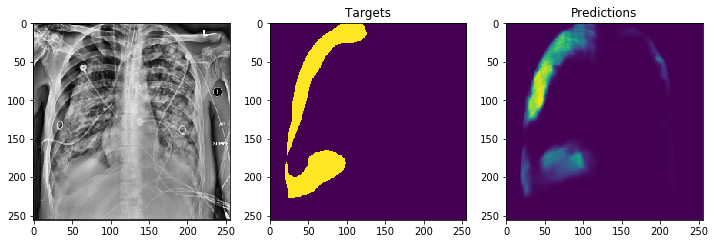

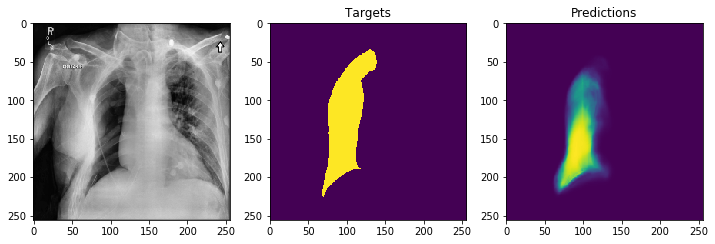

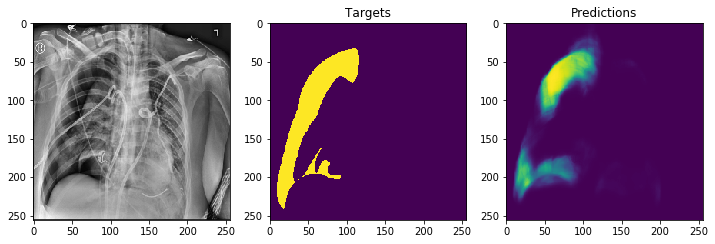

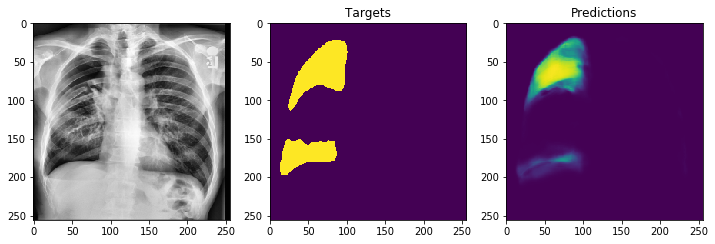

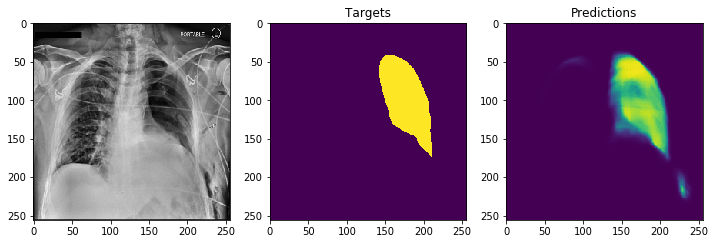

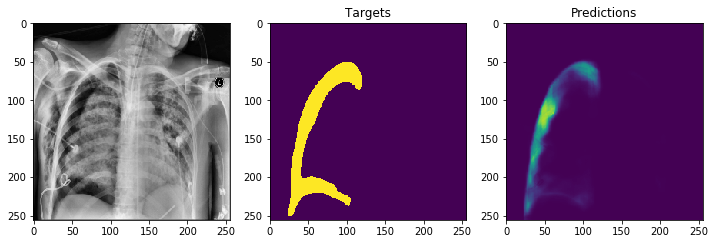

In [38]:
# Plot some samples
rows = 10
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

In [ ]:
learn.show_results(rows=30, figsize=(20,20))